# MaSim Country Calibration

This note book is used for running the country calibration processes for eventual use in the experimental simulation process. This notebook and the accompanying toolkit was developed by James Brodovsky and Sarit Adhikari as part of the calibration efforts for Burkino Faso and Mozambique in 2025.

## Installation

The preferred use case is to install the toolbox package locally into a virtual environment. If you have cloned this repository, you can install the package using pip. 

```bash
pip install -e .
```

If you are using `uv` (and you should!) install via

```bash
uv pip install -e .
```

This will install the package in editable mode, allowing you to make changes to the code and have them reflected in your local environment. If for some reason you are not seeing the changes reflected, try re-installing the package locally using the above commands again.

Alternatively, and this should be done only if you are developing additional toolbox features, you can run this notebook from the root (top level) directory and direct import calls to the toolbox via 

```python 
from src.masim_analysis import *
```
where `*` is the specific module you are interested in.

## Package and repo structure

Please make note of the following directory structures: `conf` and `data`. These are the primary two directories for experimental country data and configuration files. The `conf` directory contains the configuration (.yml) files for the simulation, while the `data` directory contains the data files used in the simulation (typically raster files).

Each of these folders is organized by country. For example, if you are working with Mozambique, the directory structure would look like this:

```
data/
    moz/
        calibration/
        ...
conf/
    moz/
        calibration/
        ...
```
Additionally the templates folder contains the template files for the configuration files. These are used to generate the .yml files for the simulation.

## How to use this notebook

This notebook should be thought of as a structured interactive prompt. The notes sections guide you through the process of calibrating and validating a country. The code sections are generally organized into sections that can be run independently. The notebook breaks up individual workflows by using markdown headings and note blocks. Due to the some what long-running nature of the tasks that calibration and validation involve, you'll sometimes have to wait and shutdown the kernel the notebook is running on and pick up where you left off another time.

To that end, this notebook is designed to make things organized but also segmented. Keep calibration constants (name, population, etc.) in a block below this and make sure to run that block every time you start the notebook. Module and library imports should be handled in the workflow segment you are currently working on. It is recommend (for speed of execution) to separate out imports from code execution to save time on re-importing.

Workflows are generally separated by a horizontal rule:

---

## Calibration efforts

The primary calibration point is to relate the beta parameter (rate of infection/biting) with the population size of a given map pixel given that pixel's treatment access rate. This involves a few steps. As a preliminary step, obtain the relevant raster files that contain population data, district mapping values, treatment, and prevalence (pfpr2-10, or a similar name) and place it under `data/<country>`. fictitious calibration data will be stored under `data/<country>/calibration`. Create a new branch in the git repository for the calibration process. This is important to keep track of changes and to avoid conflicts with the main branch. The main branch should be reserved for strategy and treatment analysis. The workflow there should be to branch off from the main branch, implement the strategies and treatments, and then merge back in any useful changes. Strategy and treament analysis shouldn't be a main contribution to the main branch. The calibration branch name should be descriptive and include the country name, e.g., `calibration-moz`.

Calibration then occurs in two phases and should be done on a separate git branch. The first phase is generating the simulated data for beta calibration. This creates the fictitious configuration and data files. This concludes with several command and job files to be run on a cluster. At the moment this is configured to work on Temple University's OwlsNest cluster, but the resulting `*_cmds.txt` files simply contain a list of shell commands that execute the simulation and should be generalizable to whatever parallel computing cluster system you are using.

The second phase is started when the batch processing is completed and downloaded locally to the `output/<country>/calibration` directory. These files are then summarized and the prevalence and beta values are fit using a log-sigmoid curve fit when broken down by pixel population and treatment access rate. These fits are then used to generate the beta map for eventual use in the experimental simulation.

---

## Constants

These are the country specific parameters you are working within. Please run the below code block every time you start this notebook.

- `name`: The country code name. Usually two or three letters. Examples: `moz` for Mozambique, `bf` for Burkino Faso, `rwa` for Rwanda, `tz` for Tanzania, etc.
- `birth_rate`: The birth rate of the country. This is used to calculate the population growth rate. This is usually a constant value for the country. Data is typically given in births per 1000 people. Normalize that data to a decimal value.
- `target_population`: The population of the country in the calibration target year.
- `initial_age_structure`: The initial age bins of the country. 
- `age_distribution`: The age distribution of the country as percentages corresponding to the age bins.
- `death_rate`: The death rate of the country corresponding to the age bins.
- `access_rates`: the treatment access rates for the country. This is determined by the unique values in the raster file typically called `<name>_treatementseeking.asc`


In [1]:
import numpy as np
import pandas as pd
from masim_analysis import utils, configure
from masim_analysis.configure import ConfigureParams
import os
from datetime import date
from ruamel.yaml import YAML

yaml = YAML()

# --- Input parameters ---
# These are theconstants for each calibration permutation that we know from population data
name = "moz"

# Population structure
initial_age_structure = [1, 5, 9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 100] # Different from the MaSim age_structure
age_distribution = [0.037, 0.132, 0.161, 0.142, 0.090, 0.086, 0.070, 0.052, 0.044, 0.044, 0.031, 0.041, 0.024, 0.017, 0.013, 0.017]

# Growth rate and population parameters
birth_rate = 40.52 / 1000 # 2011 crude birth rate
target_population, _ = utils.read_raster(os.path.join("data", name, f"{name}_population.asc"))
target_population = np.nansum(target_population)  # Total population for the target year
initial_population, _ = utils.read_raster(os.path.join("data", name, f"{name}_initialpopulation.asc"))
initial_population = np.nansum(initial_population)  # Initial population for the target year
target_growth_rate = (target_population - initial_population) / initial_population
#death_rate = [0.049744, 0.064331, 0.064331, 0.064331, 0.064331, 0.00359, 0.00361, 0.00365, 0.00379, 0.00379, 0.133, 0.133, 0.0174, 0.0174, 0.0174] # original
death_rate = [0.048140, 0.041605, 0.052070, 0.048057, 0.048057, 0.00497, 0.00497, 0.00497, 0.00497, 0.003540, 0.00354, 0.00758, 0.01113, 0.01113, 0.01113]

# Get the unique treatment access rates
treatment, _ =  utils.read_raster(os.path.join("data", name, f"{name}_treatmentseeking.asc"))
access_rates = np.unique(treatment)
access_rates = access_rates[~np.isnan(access_rates)]
access_rates = np.sort(access_rates)
access_rates = access_rates.tolist()

# --- Tuneable parameters ---
# These are the parameters that we will be tuning in the calibration process to develop a model that
# relates the prevelence data to population, access rates, and betas.
betas = [0.001, 0.005, 0.01, 0.0125, 0.015, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1]
population_bins = [10, 20, 30, 40, 50, 75, 100, 250, 500, 1000, 2000, 5000, 10000, 15000, 20000]

# --- Calibration parameters ---
# These are the target year for the data available as well as the number 
# of repetitions for each calibration combination. These variables 
# are constant for each calibration permutation
calibration_year = 2022 
reps = 20

# --- Derived dates ---
starting_date=date(calibration_year-11, 1, 1).strftime("%Y/%m/%d")
ending_date=date(calibration_year+1, 12, 31).strftime("%Y/%m/%d")
start_of_comparison_period=date(calibration_year, 1, 1).strftime("%Y/%m/%d")

### Raster data exploration

The first step is to read in the relevant rasters to get a sense of some of the big picture data. The rasters are stored in the `data/<country>` directory. This is then used to get some basic statistics to run calibration. Of primary concern is getting the value of the initial population, calibration year population, `

In [2]:
districts, _ =  utils.read_raster(os.path.join("data", name, f"{name}_districts.asc"))
population, _ = utils.read_raster(os.path.join("data", name, f"{name}_initialpopulation.asc"))
prevalence, _ = utils.read_raster(os.path.join("data", name, f"{name}_pfpr210.asc"))
district_names = pd.read_csv(os.path.join("data", name, f"{name}_mapping.csv"), index_col="ID")
names = district_names.to_dict()["DISTRICT"]

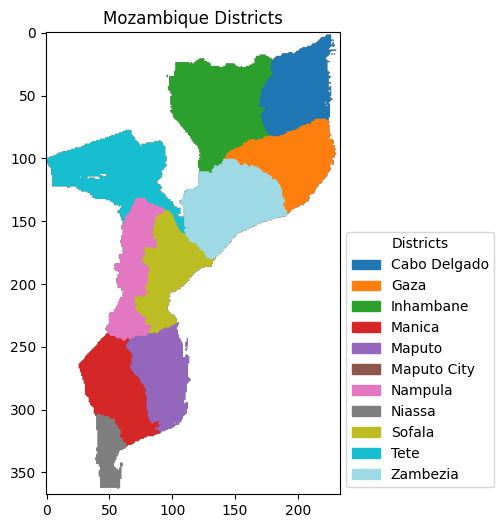

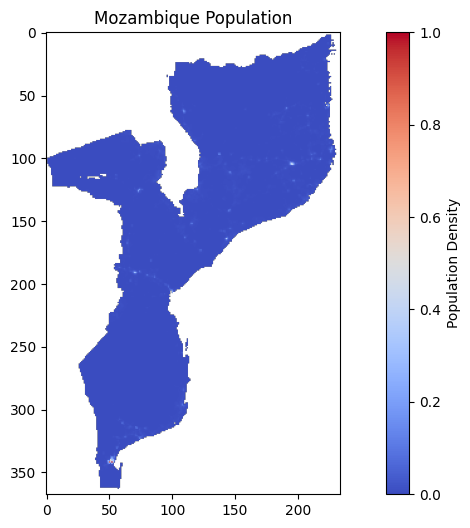

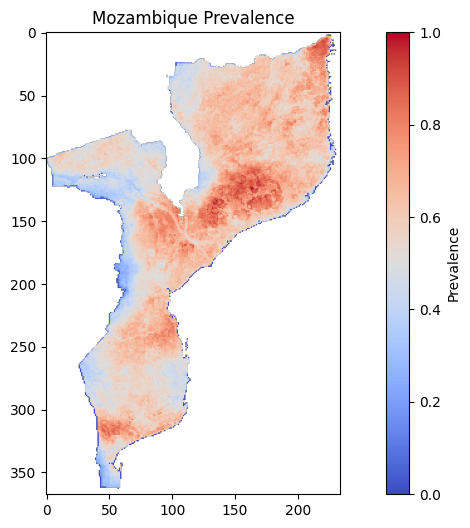

In [3]:
dist_fig = utils.plot_districts(districts, names, "Mozambique", fig_size=(12, 6), loc="lower right", bbox_to_anchor=(1.55, 0))
pop_fig = utils.plot_population(population, "Mozambique", fig_size=(12, 6))
pfpr_plot = utils.plot_prevalence(prevalence, "Mozambique", fig_size=(12, 6))

### Drug distribution rates

Each country has a different drug distribution rate. This will factor into the calibration file. For instances, Mozambique's distribution is as follows:

In [4]:
drug_distribution = pd.read_csv(os.path.join("data", name, f"{name}_drugdistribution.csv"), index_col=0, na_values=-99)
drug_distribution

,AL,quin,sp,cq,aq,as,other,asaq,aspirin
date,,,,,,,,,
2003,NaN,10.7,10.7,14.9,NaN,14.9,9.8,NaN,7.0
2011,NaN,8.5,23.8,2.8,2.0,NaN,4.6,59.9,NaN
2015,NaN,0.4,7.2,0.3,0.2,NaN,1.5,92.6,NaN
2018,NaN,0.6,0.7,0.3,0.2,0.5,0.2,98.0,NaN
2022,NaN,2.6,2.9,NaN,2.8,6.0,1.4,85.0,NaN
2023,NaN,2.6,2.9,NaN,2.8,6.0,1.4,85.0,NaN


In [5]:
drug_distribution.drop(2003, inplace=True)

In [6]:
drug_distribution.drop(columns=['AL', 'aspirin'], inplace=True)

In [7]:
drug_distribution

,quin,sp,cq,aq,as,other,asaq
date,,,,,,,
2011,8.5,23.8,2.8,2.0,NaN,4.6,59.9
2015,0.4,7.2,0.3,0.2,NaN,1.5,92.6
2018,0.6,0.7,0.3,0.2,0.5,0.2,98.0
2022,2.6,2.9,NaN,2.8,6.0,1.4,85.0
2023,2.6,2.9,NaN,2.8,6.0,1.4,85.0


As a santiy check, the sum of the distribution rates should equal 1.0 for each year.

In [8]:
drug_distribution["sum"] = drug_distribution.sum(axis=1)
drug_distribution

,quin,sp,cq,aq,as,other,asaq,sum
date,,,,,,,,
2011,8.5,23.8,2.8,2.0,NaN,4.6,59.9,101.6
2015,0.4,7.2,0.3,0.2,NaN,1.5,92.6,102.2
2018,0.6,0.7,0.3,0.2,0.5,0.2,98.0,100.5
2022,2.6,2.9,NaN,2.8,6.0,1.4,85.0,100.7
2023,2.6,2.9,NaN,2.8,6.0,1.4,85.0,100.7


In [9]:
totals = drug_distribution["sum"]
drug_distribution.drop(columns=["sum"], inplace=True)
drug_distribution = drug_distribution.div(totals, axis=0)
drug_distribution

,quin,sp,cq,aq,as,other,asaq
date,,,,,,,
2011,0.083661,0.234252,0.027559,0.019685,NaN,0.045276,0.589567
2015,0.003914,0.070450,0.002935,0.001957,NaN,0.014677,0.906067
2018,0.005970,0.006965,0.002985,0.001990,0.004975,0.001990,0.975124
2022,0.025819,0.028798,NaN,0.027805,0.059583,0.013903,0.844091
2023,0.025819,0.028798,NaN,0.027805,0.059583,0.013903,0.844091


We then relate this to the `DRUG_DB` and `THERAPY_DB` dictionary in `masim_analysis.configure`. Note that the drug distribution may be either a single drug or a combination of drugs. For instance, `al` is a combination of artemether and lumefantrine. This would correspond to a 

In [10]:
from masim_analysis.configure import DRUG_DB, THERAPY_DB
print("Drugs:")
for idx in DRUG_DB.keys():
    print(f"Drug {idx}: {DRUG_DB[idx]['name']}")
print("Therapies:")
for idx in THERAPY_DB.keys():
    drug_ids = THERAPY_DB[idx]['drug_id']
    print(f"Therapy {idx}: {[DRUG_DB[drug_id]['name'] for drug_id in drug_ids]}")

Drugs:
Drug 0: ART
Drug 1: AQ
Drug 2: SP
Drug 3: CQ
Drug 4: LUM
Drug 5: PQ
Drug 6: MF
Drug 7: QUIN
Therapies:
Therapy 0: ['ART', 'AQ']
Therapy 1: ['ART', 'LUM']
Therapy 2: ['ART', 'MF']
Therapy 3: ['ART', 'PQ']
Therapy 4: ['AQ']
Therapy 5: ['ART']
Therapy 6: ['CQ']
Therapy 7: ['QUIN']
Therapy 8: ['SP']


From this information we must manually construct the baseline strategy. Similar to the drug and therapy "databases" we store the strategies in a dictionary with integer keys. Each key corresponds to a strategy which itself is a dictionary with the following keys:
- `name`: The name of the strategy. This is used to identify the strategy in the simulation.
- `type`: The type of strategy. Leave this as "MFT" until further notice.
- `therapy_ids`: The therapy ids used in the strategy. This is a list of integers corresponding to the therapy ids in the `THERAPY_DB` dictionary.
- `distribution`: The distribution of the strategy. This is a list of floats corresponding to the distribution of the strategy that we derived from the drug distribution rates from DHS data.

In [11]:
# Note: maciek thinks that ASAQ should really be AL; going to queue up this for a temporary calibration (i.e. therapy 1 instead of 0)
os.makedirs(os.path.join("conf", name, "test"), exist_ok=True)

strategy_db = {
    0: {
        "name": "2011",
        "type": "MFT",
        "therapy_ids":  [7, 8, 6, 4, 5, 1],
        "distribution": [0.083661, 0.234252, 0.027559, 0.019685, 0, 0.589567]
    },
    1: {
        "name": "2015",
        "type": "MFT",
        "therapy_ids":  [7, 8, 6, 4, 5, 1],
        "distribution": [0.003914, 0.07045, 0.002935, 0.001957, 0, 0.014677, 0.906067]
    },
    2: {
        "name": "2018",
        "type": "MFT",
        "therapy_ids":  [7, 8, 6, 4, 5, 1],
        "distribution": [0.3005970, 0.006965, 0.002985, 0.00199, 0.004975, 0.00199, 0.975124]
    },
    3: {
        "name": "2022",
        "type": "MFT",
        "therapy_ids":  [7, 8, 6, 4, 5, 1],
        "distribution": [0.025819, 0.028798, 0, 0.027805, 0.059583, 0.013903, 0.844091]
    },
    4: {
        "name": "2023",
        "type": "MFT",
        "therapy_ids":  [7, 8, 6, 4, 5, 1],
        "distribution": [0.025819, 0.028798, 0, 0.027805, 0.059583, 0.013903, 0.844091]
    },
}
yaml.dump(strategy_db, open(os.path.join("conf", name, "test", f"strategy_db.yaml"), "w"))

events = [
    {"name": "2011_strategy", 
     "info": [{"day": starting_date, "strategy_id": 0}]   
    },
    {"name": "2015_strategy", 
     "info": [{"day": date(2015, 1, 1).strftime("%Y/%m/%d"), "strategy_id": 1}]   
    },
    {"name": "2018_strategy", 
     "info": [{"day": date(2018, 1, 1).strftime("%Y/%m/%d"), "strategy_id": 2}]   
    },
    {"name": "2022_strategy", 
     "info": [{"day": date(2022, 1, 1).strftime("%Y/%m/%d"), "strategy_id": 3}]   
    },
    {"name": "2023_strategy", 
     "info": [{"day": date(2023, 1, 1).strftime("%Y/%m/%d"), "strategy_id": 4}]   
    }
]
yaml.dump(events, open(os.path.join("conf", name, "test", f"events.yaml"), "w"))

## Birth Rate Check

The important calibration point is the final year population. We back out the population data from this using a birth rate. To check that the initialization raster is correct, we need to run an initial simulation run to verify this growth rate considering malria deaths as well. This is really just a sanity check to make sure the input data is correct.

Run an initial check to make sure the growth rate is working correctly. Given the input file for whatever year, run a single simulation and check that the population for the target year is correct. Make sure to scale the ending population by the simulation scale factor as well. Ball park the initial beta value around 10%

In [12]:
import os
from masim_analysis import analysis, calibrate

# load the previously saved strategy and event files
strategy_db = yaml.load(open(os.path.join("conf", name, "test", f"strategy_db.yaml"), "r"))
events = yaml.load(open(os.path.join("conf", name, "test", f"events.yaml"), "r"))

Next we'll create a simple simulation run to verify the population growth rate.

In [15]:
pop = 10_000
params = configure.configure(
    country_code=name,
    birth_rate=birth_rate,
    initial_age_structure=initial_age_structure,
    age_distribution=age_distribution,
    death_rates=death_rate,
    starting_date=date(calibration_year - 11, 1, 1),
    start_of_comparison_period=date(calibration_year, 1, 1),
    ending_date = date(calibration_year + 1, 1, 1),
    strategy_db=strategy_db,
    calibration_str="growth_validation",
    beta_override=0.05,
    population_override=pop,
    calibration=True,
)
params['events'].extend(events)
params['artificial_rescaling_of_population_size'] = 1.0

yaml.dump(params, open(os.path.join("conf", name, "test", f"{name}_growth_validation.yaml"), "w"))

calibrate.write_pixel_data_files(params["raster_db"], pop)

Now we'll run the simulation to verify the population growth rate.

In [ ]:
filename = os.path.join("conf", name, "test", f"{name}_growth_validation.yaml")
os.makedirs(os.path.join("output", name, "test"), exist_ok=True)
output_file = os.path.join("output", name, "test", f"{name}_growth_validation")
os.makedirs(os.path.dirname(output_file), exist_ok=True)
os.system(
    f"./bin/MaSim -i ./{filename} -o ./{output_file} -r SQLiteDistrictReporter"
)

[INFO] MaSim version 4.1.8
[INFO] Model initializing...
[INFO] Read input file: ./conf/moz/test/moz_growth_validation.yaml
[INFO] Districts loaded with 1 districs
[INFO] District_lookup loaded with 1 pixels
[INFO] location_db appears to have been set by raster_db
[INFO] Using rainfall-based seasonal information.
[INFO] Relative probability that child travels compared to adult is not set in input file, defaulting to 1.0
[INFO] Relative probability for a clinical case to travel is not set in input file, defaulting to 1.0
[INFO] Random initializing with seed: 1984916421
[INFO] Starting day is 2011-01-01
[INFO] Location count: 1
[INFO] Population size: 10000
[INFO] Model starting...
[INFO] Perform before run events
[INFO] Simulation is running
[INFO] 16:43:08 - Day: 0
[INFO] 2011-01-01 : turn mutation off
[INFO] 16:43:08 - Day: 30
[INFO] 16:43:08 - Day: 60
[INFO] 16:43:09 - Day: 90
[INFO] 16:43:11 - Day: 120
[INFO] 16:43:15 - Day: 150
[INFO] 16:43:21 - Day: 180
[INFO] 16:43:31 - Day: 210
[

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
data = analysis.get_table(f"{output_file}monthly_data_0.db", "monthlysitedata")
starting_pop = data[data["monthlydataid"] == 1]["population"].sum()
last_month = data["monthlydataid"].unique()[-1]
population_by_month = [data[data["monthlydataid"] == month]["population"].sum() for month in data["monthlydataid"].unique()]
population_by_month = np.array(population_by_month)
ending_population = population_by_month[-1]
growth_rate = (ending_population - starting_pop) / starting_pop
print(f"Starting population: {starting_pop}")
print(f"Ending population: {ending_population}")
print(f"Growth rate: {growth_rate}")
print(f"Target growth rate: {target_growth_rate}")

plt.plot(data["monthlydataid"].unique(), population_by_month, linestyle='-', color='b')
plt.xlabel("Month")
plt.ylabel("Population (millions)")
plt.title("Population by Month")
plt.show()

---

## Seasonality Calibration

Seasonality is a something of a manual process to fit precisely. The goal is to fit a curve that gives a scalar parameter that modifies the incidence rate for each day of the year. This is written to a `.csv` file historically called "adjustment" or "rainfall" and is a simple row-wise list of scalar values that effect the overall incidence or biting rate. This notebook choose to save this output as `seasonality.csv` in the `data/<country>/calibration` directory.

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt

cuamba = pd.read_csv(os.path.join("data", name, "calibration", "incidence cuamba.csv"))
inharrime = pd.read_csv(os.path.join("data", name, "calibration", "incidence inharrime.csv"))
c = cuamba[['month_num', 'cases/thousand']].copy()
i = inharrime[['month_num', 'cases/thousand']].copy()
s = pd.concat([c, i], axis=0)
s = s.dropna()

x = s['month_num'].to_numpy()
y = s['cases/thousand'].to_numpy()

fig, ax = plt.subplots(figsize=(12,2))
ax.plot(x, y, '.b', label='Data')
ax.set_xlabel('Month')
ax.set_ylabel('Cases/thousand')
ax.set_title('Seasonal signal')
plt.show()

As we know from previous work, the seasonality of malaria (and most diseases) is roughly sinusoidal. The goal is to fit a sinusoidal curve to the data. With that as well the working assumption of the Boni Lab is to use the positive half of the sine curve. There is not a strong stance on this as seasonal incidence modeling is not a major research concern of the lab. Simply put, taking the positive half of the sine curve is what previous publications from the lab has done and to avoid unneccesary problems in the peer review process, we will continue to do this. This notebook will walk through the process for the full sine curve for completeness' sake.

The fitting is done using the `scipy.optimize.curve_fit` function. The function takes in a model function and the data to fit. The model function is a sinusoidal function with a phase shift, period, amplitude, and offset.

$$
s(x) = A \sin\left(\frac{2 \pi x}{P} + \phi\right) + B
$$

In [ ]:
def seasonality(x, amplitude, period, phase, offset):
    """
    Generate a seasonal signal according to a sinusoidal model.
    """
    return amplitude * np.sin((2 * np.pi / period) * (x - phase)) + offset

def seasonality_positive_sine(x, amplitude, period, phase, offset):
    """
    Generate a seasonal signal according to a sinusoidal model.
    """
    s = seasonality(x, amplitude, period, phase, offset)
    s[s <= offset] = offset
    return s

We are looking to fit a scalar multiplier of the base incidence data not a curve over the specific incidence. We can do this by normalizing the incidence data about the median, mean, or mode.

In [ ]:
from scipy.stats import mode as spmode

median = np.median(y)
mean = np.mean(y)
mode = spmode(y)

In [ ]:
fig, ax = plt.subplots(figsize=(12,2))
ax.plot(x, y, '.b', label='Data')
ax.set_xlabel('Month')
ax.set_ylabel('Cases/thousand')
ax.set_title('Seasonal signal')
ax.axhline(median, color='r', linestyle='--', label='Median')
ax.axhline(mean, color='g', linestyle='--', label='Mean')
ax.axhline(mode.mode, color='y', linestyle='--', label='Mode')
ax.legend(loc='upper right', bbox_to_anchor=(1.12, 1))
plt.show()

Normailze the data with respect to the mean value.

In [ ]:
y_norm = y / mean

fig, ax = plt.subplots(figsize=(12,2))
ax.plot(x, y_norm, '.b', label='Normalized Data')
ax.set_xlabel('Month')
ax.set_ylabel('Cases / thousand')
ax.set_title('Seasonal signal')
ax.axhline(median / mean, color='r', linestyle='--', label='Normalized Median')
ax.axhline(mean / mean, color='g', linestyle='--', label='Normalized Mean')
ax.axhline(mode.mode / mean, color='y', linestyle='--', label='Normalized Mode')
ax.legend(loc='upper right', bbox_to_anchor=(1.22, 1))
plt.show()

Run the curve fit function and analyze with resepct to both the full sinusoid and the positive half of the sine curve.

In [ ]:
from scipy.optimize import curve_fit

fit = curve_fit(seasonality, x, y_norm, p0=[1, 365, 0, 1], maxfev=10000)

coefs = fit[0]

t = np.linspace(1, 12, 1000)

full_sine = seasonality(x, *coefs)
r2 = 1 - (np.sum((y_norm - full_sine)**2) / np.sum((y_norm - np.mean(y_norm))**2))
std_dev = np.std(y_norm - full_sine)

positive_sine = seasonality_positive_sine(x, *coefs)
r2_positive = 1 - (np.sum((y_norm - positive_sine)**2) / np.sum((y_norm - np.mean(y_norm))**2))
std_dev_positive = np.std(y_norm - positive_sine)

fig, ax = plt.subplots(figsize=(12, 2))
ax.plot(x, y_norm, '.b', label='Data (scaled)')
ax.plot(t, seasonality(t, *coefs), 'r-', label=f'Fitted curve\n$r^2$ = {r2:0.2f}\n$\sigma$: {std_dev:0.2f}')
ax.plot(t, seasonality_positive_sine(t, *coefs), 'g--', label=f'Fitted curve (positive sine)\n$r^2$ = {r2_positive:0.2f}\n$\sigma$: {std_dev_positive:0.2f}')
ax.set_xlabel('Month')
ax.set_ylabel('Incidence Scalar')
ax.legend(loc="upper right", bbox_to_anchor=(1.28, 1))
plt.show()

The fit is not great, but this is a relatively minor aspect of the simulation. The point is to introduce some degree of seasonal variation that is reasonable. Now let's transform the fit back to the incidence rate.

In [ ]:
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(x, y, '.b', label='Data (scaled)')
ax.plot(t, seasonality_positive_sine(t, *coefs) * mean, 'g--', label='Fitted curve; $r^2$ = %.2f' % r2)
ax.legend()
plt.show()

In [ ]:
# Write the fit to a file for 365 days
fit_x = np.arange(1, 366)
fit_y = seasonality_positive_sine(fit_x, *fit[0])
data = pd.DataFrame({"day": fit_x, "cases/thousand": fit_y})
data.index = data["day"]
data = data.drop(columns=["day"])
data.to_csv(os.path.join("data", name, f"{name}_seasonality.csv"), index=False, header=False)

## Run calibration data generation

The unknown that we are trying to solve for is the beta value(s). We have _real_ pixel-wise _prevalence_ (pfpr2-10) data that arrises from a given beta. The goal is to generate data that matches closely the real prevalence data by varying the beta value, population size, and access rate for a simulated single pixel. We will first generate the configuration files for the calibration runs here. 

In [13]:
# Country calibration script
import os
from datetime import date
from ruamel.yaml import YAML
from masim_analysis import calibrate

yaml = YAML()

In [14]:
calibrate.generate_configuration_files(
    name,
    calibration_year,
    population_bins,
    access_rates,
    betas,
    birth_rate,
    death_rate,
    initial_age_structure,
    age_distribution,
    strategy_db=strategy_db,
    events=events,
)

100%|██████████| 15/15 [05:39<00:00, 22.63s/it]


Create the command and job files

In [ ]:
calibrate.generate_command_and_job_files(
    name,
    population_bins,
    access_rates,
    betas,
    reps,
    cores=28,
    nodes=8,
)

At this point you should have all the data and configuration files you need in order to run the calibration. The next step is to commit the changes (added files) to the local branch and push to the remote branch. Log into the cluster and switch to the branch you just created:

```bash
git checkout <branch_name>
git pull
```
Create the required output directories on the cluster: 

```bash
mkdir -p output/<country>/calibration
```

Ensure that the jobs files (typically `.sh`) are only the specific jobs that you want to run. Delete any other job or `.sh` files. Keep in mind that any given user may only have at most 50 jobs queued on Owl's Nest at a time. Queue up the calibration jobs using the following command:

```bash
for i in $(ls *.sh); do
    echo "Submitting job $i"
    qsub $i
done
```

This will submit all the jobs in the current directory. Give it a few minutes to queue up and then log into your cluster account and check the status of the jobs. At steady state, each job should be running approximately 28 processess simultaneously. The lower population size pixels do not take very long to run when spread out over several nodes (4-8, approximately 15-60 minutes). The larger population sizes (10k-20k) take much longer (10-12 hours).




---

## Check for missing data

Once the jobs are completed, you will need to download the output files from the cluster. This can be done using `scp` or `rsync`. For example, to download the output files from Owl's Nest to your local machine, you can use the following command:

```bash
scp -r <username>@<cluster_address>:Temple-Malaria-Simulation-Analysis/output <local_path>
```
This will download the output files to the specified local path. I recommend simply copying them to your desktop. Once you have downloaded the output files, copy them to this repo (or download directly) and place them in the `output/<country>/calibration` directory. This will allow you to run the analysis on the simulated data locally.

Assuming that all or most of the calibration simulation executed successfull, delete all job and commands files in the local repository. Do not delete the files on the cluster! This will cause a git tracking issue as the repository branches will be out of sync.

Prior to running the full calibration analysis, check for any missing data files. Sometimes Owl's Nest gets hung, the database file didn't write correctly, the job times out, or some other bug happened. First, a sanity check. We should have the following number of output calibration files.

In [ ]:
import os

needed_files = len(population_bins) * len(access_rates) * len(betas) * reps
output_dir = os.path.join("output", name, "calibration")
output_files = os.listdir(output_dir)
completed_files = len(output_files)

print(f"Total calibration files: {needed_files}")
print(f"Completed calibration files: {completed_files}")
print(f"Missing calibration files: {needed_files - completed_files}")

If there are missing files use the below block to check for the missing output and create the appropriate job and commands files. You should also double check that each permutation is completed using `process_missing_jobs` prior to moving onto the calibration curve fitting. If there are no missing files proceed to the next section.

In [ ]:
import os
import pandas as pd
from datetime import date
from masim_analysis import calibrate

base_file_path = os.path.join("output", name, "calibration")
summary = pd.DataFrame(columns=["population", "access_rate", "beta", "iteration", "pfprunder5", "pfpr2to10", "pfprall"])

comparison = date(calibration_year, 1, 1)
year_start = comparison.strftime("%Y-%m-%d")
year_end = (comparison + pd.DateOffset(years=1)).strftime("%Y-%m-%d")

In [ ]:
calibrate.process_missing_jobs(
    name,
    population_bins,
    access_rates,
    betas,
    os.path.join("output"),
    reps,
)

If there are any missing data files run them on the cluster. This can be done by running the following command:

```bash
qsub missing_calibration_runs_<pop>_job.sh
```

---

### Summarize data

Once all the appropriate calibration data has been collected we need to summarize across all the individual data files. This will write the summarized results to `calibration_summary.csv` file in the `output/<country>/calibration` directory. The summary file will contain the following columns:
- `beta`: the beta value used in the simulation
- `population`: the population size of the pixel
- `access_rate`: the treatment access rate of the pixel
- `pfpr2_10`: the pfpr2-10 value of the pixel
- `pfprunder5`: the mean pfpr under 5 value of the pixel
- `pfprall`: the mean pfpr value of the pixel
- `iteration` : the iteration number of the simulation


In [ ]:
summary = calibrate.summarize_calibration_results(
    name,
    population_bins,
    access_rates,
    betas,
    calibration_year,
    os.path.join("output"),
    reps,
)
summary.to_csv(f"{base_file_path}/calibration_means.csv", index=False)

---

## Curve fitting

Now that we have summarized data that connects population size, treatment access, transmission rate, and prevelence, we can fit the data to a linear and log-sigmoid curve. Generally, the log-sigmoid appears to model the relationship better, but both methods are here for reference. This will allow us to generate a beta map for the experimental simulation. The beta map is generated by taking the beta value that corresponds to the population size and treatment access rate of each pixel. This is done using the `generate_beta_map` function, which takes the summarized data and generates a beta map for the experimental simulation.

In [ ]:
import json

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

from masim_analysis import calibrate

base_file_path = os.path.join("output", name, "calibration")
means = pd.read_csv(f"{base_file_path}/calibration_means.csv")

### Linear fit

We're looking to fit the pfpr to beta relationship so that we can then use the real pfpr value from the raster data to determine the beta value. So, given a specific pixel's population, pfpr, and access rate (treatmentseeking?) calculate the beta value from this fitting method. We also don't have a decent way to serialize the linear models returned from sklearn, so at the moment this is just here for demonstration purposes.

Start using linear regression.

In [ ]:
# Determine grid size
num_rows = len(population_bins)
num_cols = len(access_rates)

# Create subplots grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows), sharex=True, sharey=True)

# Ensure axes is always a 2D list for consistency
if num_rows == 1:
    axes = np.array([axes])  # Convert to 2D array
if num_cols == 1:
    axes = np.array([[ax] for ax in axes])  # Convert to 2D array

# Perform regression for each (Population, TreatmentAccess) group
for i, population in enumerate(population_bins):
    for j, treatment_access in enumerate(access_rates):
        ax = axes[i, j]  # Select subplot location

        # Filter the data for the current Population and TreatmentAccess
        group = means[(means["population"] == population) & (means["access_rate"] == treatment_access)]

        if group.empty:
            ax.set_visible(False)  # Hide empty plots
            continue

        group = group.dropna(axis=0)  # drop any row in a nan column

        X = group[["beta"]].values
        y = group["pfpr2to10"].values

        # 1. Linear Regression
        model = LinearRegression()
        model.fit(X, y)

        # 2. Polynomial Regression (degree 3)
        poly_model3 = make_pipeline(PolynomialFeatures(3), LinearRegression())
        poly_model3.fit(X, y)

        # 3. Polynomial Regression (degree 5)
        poly_model5 = make_pipeline(PolynomialFeatures(5), LinearRegression())
        poly_model5.fit(X, y)

        # 4. Spline Regression
        # spline_model = UnivariateSpline(group['beta'], group['pfpr2to10'], s=50)

        # Plot regression
        sns.scatterplot(x=group["beta"], y=group["pfpr2to10"], ax=ax, label="Data", color="black")
        ax.plot(group["beta"], model.predict(X), color="red", linestyle="dashed", label="Linear")
        ax.plot(group["beta"], poly_model3.predict(X), color="blue", linestyle="dashed", label="Poly (3)")
        ax.plot(group["beta"], poly_model5.predict(X), color="green", linestyle="dashed", label="Poly (5)")
        # ax.plot(group['Beta'], spline_model(X), color='purple', linestyle="dashed", label="Spline")

        # Setting titles & labels
        ax.set_title(f"Population : {population}, Access : {treatment_access}")
        if j == 0:
            ax.set_ylabel("pfpr2to10")
        if i == num_rows - 1:
            ax.set_xlabel("Beta")
        ax.legend(fontsize=7)

# Adjust layout
plt.suptitle("Curve Fitting by Population & Treatment Access", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Now we'll do a logarithemic fit for the beta value and attempt to fit a sigmoid curve. Again this is the model that typically works best for the data. The fit returned is a list of the parameters for the sigmoid function which can be easily serialized and saved to a file. The sigmoid function is defined as:

$$s = \frac{a}{1 + e^{-b(x - c)}}$$

which in code is:

```python
def sigmoid(x, a, b, c):
    return a / (1 + np.exp(-b * (x - c)))
```
where `a`, `b`, and `c` are the parameters of the sigmoid function. The `x` value is the beta value. The `a` parameter is the maximum value of the sigmoid function, the `b` parameter is the steepness of the curve, and the `c` parameter is the x-value of the sigmoid's midpoint.

In [ ]:
models_map = calibrate.log_sigmoid_fit(
    population_bins,
    access_rates,
    means,
)

In [ ]:
f = calibrate.plot_log_sigmoid(population_bins, access_rates, means, models_map)

Write the calibrated log-sigmoid model to a file. The most straightforward way to do this is to serialize the model dictionary to a `.json` file. The built in `json` module easily handles this for Python dictionaries. This way the data is written out in a human readable and cross language format. One change that needs to be made is to convert the numpy arrays to lists.

In [ ]:
for rate in models_map.keys():
    for pop in models_map[rate].keys():
        model = models_map[rate][pop]
        models_map[rate][pop] = model.tolist()

with open(os.path.join("data", name, "calibration", "models_map.json"), 'w') as f:
    json.dump(models_map, f, indent=4)

---

Keep in mind that the built in JSON serialization and deserialization reads in all the values as strings. To get around this use `load_beta_model` from the `calibrate` module instead of the native `json.load()` function. This will convert the values back to numeric values and lists where appropriate.

In [ ]:
from src.masim_analysis import calibrate, utils
import os
from matplotlib import pyplot as plt

In [ ]:
models_map = calibrate.load_beta_model(os.path.join("data", name, "calibration", "models_map.json"))

We can then use this model to generate the beta map for the experimental simulation. The beta map is generated by taking the beta value that corresponds to the population size and treatment access rate of each pixel. This is done using the `create_beta_map` function, which takes the summarized data and generates a beta map for the experimental simulation.

In [ ]:
population, _ = utils.read_raster("data/moz/moz_population.asc")
prevalence, _ = utils.read_raster("data/moz/moz_pfpr210.asc")
treatment, _ =  utils.read_raster("data/moz/moz_treatmentseeking.asc")
beta_map = calibrate.create_beta_map(models_map, population, treatment, prevalence)

In [ ]:
plt.imshow(beta_map, cmap="hot")
plt.colorbar(label="Beta")

In [ ]:
utils.write_raster(beta_map, os.path.join("data", name, f"{name}_beta.asc"), 195196.26821073, 7004178.4200866)

---

## Validation

The validation process is similar to the calibration process except that we now use the fitted modelled beta map to attempt to recreate the prevelance map.

In [ ]:
from masim_analysis import configure, commands
import os
from datetime import date

In [ ]:
comparison = date(calibration_year, 1, 1)
start = date(calibration_year - 11, 1, 1)
end = date(calibration_year + 1, 12, 31)

execution_control = configure.main(
    name,
    start.strftime("%Y/%m/%d"),
    end.strftime("%Y/%m/%d"),
    comparison.strftime("%Y/%m/%d"),
    calibration=True,
)
execution_control["birth_rate"] = birth_rate
execution_control["death_rate"] = death_rate
execution_control["age_distribution"] = age_distribution
execution_control["strategy_db"] = {
    0: {
        "name": "baseline",
        "type": "MFT",
        "therapy_ids": [0],
        "distribution": [1],
    },
}
execution_control["initial_strategy_id"] = 0
execution_control["events"] = [
    {"name": "turn_off_mutation", "info": [{"day": start.strftime("%Y/%m/%d")}]},
]

execution_control["seasonal_info"] = {
    "enable": True,
    "mode": "rainfall",
    "rainfall": {
        "filename": os.path.join("data", name, f"{name}_seasonality.csv"),
        "period": 365,
    },
}

execution_control["raster_db"] = configure.validate_raster_files(
                    "moz",
                    calibration=True,
                    age_distribution=age_distribution,
                )

In [ ]:
full_params = configure.configure(params)
yaml.dump(full_params, open(os.path.join("conf", name, "validation.yml"), "w"))

In [ ]:
from masim_analysis import commands
file, cmds = commands.generate_commands("./conf/moz/validation4.yml", "./output/moz/validation/", 20)

In [ ]:
with open("moz_validation.txt", "w") as f:
    for cmd in cmds:
        f.write(cmd + "\n")

In [ ]:
commands.generate_job_file(
    "moz_validation.txt",
    "validation",
    cores_override=4,
    nodes_override=4,
)

In [ ]:
os.system(cmds[0])

Alright I'm having some issues with the validation yaml file. I'm going to use the section below to test out the configuration process.

In [ ]:
drug_db = configure.load_yaml("templates/drug_db.yml")

In [ ]:
therapy_db = configure.load_yaml("templates/therapy_db.yml")
therapy_db

In [ ]:
val = configure.load_yaml("conf/moz/validation2.yml")

In [ ]:
val

In [ ]:
val4 = {'days_between_notifications': 30, 'initial_seed_number': 0, 'connection_string': 'host=masimdb.vmhost.psu.edu dbname=moznda user=sim password=sim connect_timeout=60', 'record_genome_db': True, 'report_frequency': 30, 'starting_date': '2003/1/1', 'start_of_comparison_period': '2020/1/1', 'ending_date': '2035/1/1', 'start_collect_data_day': 1826, 'number_of_tracking_days': 11, 'transmission_parameter': 0.55, 'number_of_age_classes': 15, 'age_structure': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 15, 20, 60, 100], 'initial_age_structure': [1, 5, 9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 100], 'artificial_rescaling_of_population_size': 0.25, 'raster_db': {'population_raster': './data/moz/moz_population.asc', 'district_raster': './data/moz/moz_districts.asc', 'pr_treatment_under5': './data/moz/moz_treatmentseeking.asc', 'pr_treatment_over5': './data/moz/moz_treatmentseeking.asc', 'beta_raster': './data/moz/moz_beta.asc', 'cell_size': 5, 'age_distribution_by_location': [[0.037, 0.132, 0.161, 0.142, 0.09, 0.086, 0.07, 0.052, 0.044, 0.044, 0.031, 0.041, 0.024, 0.017, 0.013, 0.017]], 'p_treatment_for_less_than_5_by_location': [-1], 'p_treatment_for_more_than_5_by_location': [-1], 'beta_by_location': [0.55]}, 'seasonal_info': {'enable': False, 'mode': 'rainfall', 'rainfall': {'filename': './data/moz/moz_seasonality.csv', 'period': 365}}, 'spatial_model': {'name': 'Wesolowski', 'Wesolowski': {'kappa': 0.01093251, 'alpha': 0.22268982, 'beta': 0.14319618, 'gamma': 0.83741484}}, 'birth_rate': 0.0288, 'death_rate_by_age_class': [0.049744, 0.064331, 0.064331, 0.064331, 0.064331, 0.00359, 0.00361, 0.00365, 0.00379, 0.00379, 0.133, 0.133, 0.0174, 0.0174, 0.0174], 'mortality_when_treatment_fail_by_age_class': [0.04, 0.02, 0.02, 0.02, 0.02, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.001, 0.001, 0.001, 0.001], 'parasite_density_level': {'log_parasite_density_cured': -4.699, 'log_parasite_density_from_liver': -2.0, 'log_parasite_density_asymptomatic': 3, 'log_parasite_density_clinical': 4.301, 'log_parasite_density_clinical_from': 3.301, 'log_parasite_density_clinical_to': 5.301, 'log_parasite_density_detectable': 1.0, 'log_parasite_density_detectable_pfpr': 1.699, 'log_parasite_density_pyrogenic': 3.398}, 'immune_system_information': {'b1': 0.00125, 'b2': 0.0025, 'duration_for_naive': 300, 'duration_for_fully_immune': 60, 'mean_initial_condition': 0.1, 'sd_initial_condition': 0.1, 'immune_inflation_rate': 0.01, 'max_clinical_probability': 0.99, 'immune_effect_on_progression_to_clinical': 4, 'age_mature_immunity': 10, 'factor_effect_age_mature_immunity': 1, 'midpoint': 0.4}, 'circulation_info': {'max_relative_moving_value': 35, 'number_of_moving_levels': 100, 'moving_level_distribution': {'distribution': 'Gamma', 'Exponential': {'scale': 0.17}, 'Gamma': {'mean': 5, 'sd': 10}}, 'circulation_percent': 0.00336, 'length_of_stay': {'mean': 5, 'sd': 10}}, 'initial_parasite_info': [{'location_id': -1, 'parasite_info': [{'parasite_type_id': 32, 'prevalence': 0.05}, {'parasite_type_id': 36, 'prevalence': 0.05}]}], 'events': [{'name': 'turn_off_mutation', 'info': [{'day': '2003/1/1'}]}], 'drug_db': {0: {'name': 'ART', 'half_life': 0.0, 'maximum_parasite_killing_rate': 0.999, 'n': 25, 'age_specific_drug_concentration_sd': [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4], 'mutation_probability': 0.005, 'affecting_loci': [2], 'selecting_alleles': [[1]], 'k': 4, 'EC50': {'..0..': 0.75, '..1..': 1.2}}, 1: {'name': 'LUM', 'half_life': 4.5, 'maximum_parasite_killing_rate': 0.99, 'n': 20, 'age_specific_drug_concentration_sd': [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4], 'mutation_probability': 0.005, 'affecting_loci': [0, 1], 'selecting_alleles': [[0], [0, 2, 3, 4, 6, 7]], 'k': 4, 'EC50': {'00...': 0.8, '01...': 0.67, '02...': 0.9, '03...': 0.8, '04...': 1.0, '05...': 0.87, '06...': 1.1, '07...': 1.0, '10...': 0.75, '11...': 0.6, '12...': 0.85, '13...': 0.75, '14...': 0.95, '15...': 0.8, '16...': 1.05, '17...': 0.95}}, 2: {'name': 'QUIN', 'half_life': 18, 'maximum_parasite_killing_rate': 0.9, 'n': 3, 'age_specific_drug_concentration_sd': [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4], 'mutation_probability': 0.0, 'affecting_loci': [], 'selecting_alleles': [], 'k': 4, 'EC50': {'0....': 1.41, '1....': 1.41}}, 3: {'name': 'PQ', 'half_life': 28.0, 'maximum_parasite_killing_rate': 0.9, 'n': 15, 'age_specific_drug_concentration_sd': [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4], 'mutation_probability': 0.005, 'affecting_loci': [3], 'selecting_alleles': [[1]], 'resistant_factor': [[1]], 'k': 4, 'EC50': {'...0.': 0.58, '...1.': 1.4}}, 4: {'name': 'amodiaquine', 'half_life': 9.0, 'maximum_parasite_killing_rate': 0.95, 'n': 19, 'age_specific_drug_concentration_sd': [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4], 'mutation_probability': 0.005, 'affecting_loci': [0, 1], 'selecting_alleles': [[1], [0, 1, 3, 4, 5, 7]], 'k': 4, 'EC50': {'00...': 0.62, '01...': 0.85, '02...': 0.5, '03...': 0.775, '04...': 0.62, '05...': 0.85, '06...': 0.5, '07...': 0.775, '10...': 0.7, '11...': 0.9, '12...': 0.65, '13...': 0.82, '14...': 0.7, '15...': 0.9, '16...': 0.65, '17...': 0.82}}}, 'tf_testing_day': 28, 'therapy_db': {0: {'drug_id': [0, 1], 'dosing_days': [3]}, 1: {'drug_id': [0], 'dosing_days': [3]}, 2: {'drug_id': [2], 'dosing_days': [7]}, 3: {'drug_id': [0, 3], 'dosing_days': [3]}, 4: {'drug_id': [0, 1], 'dosing_days': [4]}, 5: {'drug_id': [0, 1], 'dosing_days': [5]}, 6: {'drug_id': [0, 4], 'dosing_days': [3]}, 7: {'drug_id': [0, 1, 4], 'dosing_days': [3]}}, 'strategy_db': {0: {'name': 'moznda-Baseline', 'type': 'MFT', 'therapy_ids': [0], 'distribution': [1]}, 1: {'name': 'moznda-AL4', 'type': 'MFT', 'therapy_ids': [6], 'distribution': [1]}, 2: {'name': 'moznda-AL5', 'type': 'MFT', 'therapy_ids': [5], 'distribution': [1]}, 3: {'name': 'moznda-ASAQ', 'type': 'MFT', 'therapy_ids': [6], 'distribution': [1]}, 4: {'name': 'moznda-DHA-PPQ', 'type': 'MFT', 'therapy_ids': [3], 'distribution': [1]}, 5: {'name': 'AL25-ASAQ75', 'type': 'MFT', 'therapy_ids': [0, 6], 'distribution': [0.25, 0.75]}, 6: {'name': 'AL50-ASAQ50', 'type': 'MFT', 'therapy_ids': [0, 6], 'distribution': [0.5, 0.5]}, 7: {'name': 'AL75-ASAQ25', 'type': 'MFT', 'therapy_ids': [0, 6], 'distribution': [0.75, 0.25]}, 8: {'name': 'AL25-DHA-PPQ75', 'type': 'MFT', 'therapy_ids': [0, 3], 'distribution': [0.25, 0.75]}, 9: {'name': 'AL50-DHA-PPQ50', 'type': 'MFT', 'therapy_ids': [0, 3], 'distribution': [0.5, 0.5]}, 10: {'name': 'AL75-DHA-PPQ25', 'type': 'MFT', 'therapy_ids': [0, 3], 'distribution': [0.75, 0.25]}, 11: {'name': 'ASAQ25-DHA-PPQ75', 'type': 'MFT', 'therapy_ids': [6, 3], 'distribution': [0.25, 0.75]}, 12: {'name': 'ASAQ50-DHA-PPQ50', 'type': 'MFT', 'therapy_ids': [6, 3], 'distribution': [0.5, 0.5]}, 13: {'name': 'ASAQ75-DHA-PPQ25', 'type': 'MFT', 'therapy_ids': [6, 3], 'distribution': [0.75, 0.25]}}, 'initial_strategy_id': 0, 'days_to_clinical_under_five': 4, 'days_to_clinical_over_five': 6, 'days_mature_gametocyte_under_five': 4, 'days_mature_gametocyte_over_five': 6, 'relative_bitting_info': {'max_relative_biting_value': 35, 'number_of_biting_levels': 100, 'biting_level_distribution': {'distribution': 'Gamma', 'Exponential': {'scale': 0.17}, 'Gamma': {'mean': 5, 'sd': 10}}}, 'gametocyte_level_under_artemisinin_action': 1.0, 'gametocyte_level_full': 1.0, 'relative_infectivity': {'sigma': 3.91, 'ro': 0.00031, 'blood_meal_volume': 3}, 'p_relapse': 0.01, 'relapse_duration': 30, 'relapseRate': 4.4721, 'update_frequency': 7, 'allow_new_coinfection_to_cause_symtoms': True, 'using_free_recombination': True, 'tf_window_size': 60, 'fraction_mosquitoes_interrupted_feeding': 0.0, 'inflation_factor': 0.01, 'genotype_info': {'loci': [{'locus_name': 'pfcrt', 'position': 0, 'alleles': [{'value': 0, 'allele_name': 'K76', 'short_name': 'K', 'can_mutate_to': [1], 'mutation_level': 0, 'daily_cost_of_resistance': 0.0}, {'value': 1, 'allele_name': '76T', 'short_name': 'T', 'can_mutate_to': [0], 'mutation_level': 1, 'daily_cost_of_resistance': 0.0005}]}, {'locus_name': 'pfmdr1', 'position': 1, 'alleles': [{'value': 0, 'allele_name': 'N86 Y184 one copy of pfmdr1', 'short_name': 'NY--', 'can_mutate_to': [1, 2, 4], 'mutation_level': 0, 'daily_cost_of_resistance': 0.0}, {'value': 1, 'allele_name': '86Y Y184 one copy of pfmdr1', 'short_name': 'YY--', 'can_mutate_to': [3, 0, 5], 'mutation_level': 1, 'daily_cost_of_resistance': 0.0005}, {'value': 2, 'allele_name': 'N86 184F one copy of pfmdr1', 'short_name': 'NF--', 'can_mutate_to': [3, 0, 6], 'mutation_level': 1, 'daily_cost_of_resistance': 0.0005}, {'value': 3, 'allele_name': '86Y 184F one copy of pfmdr1', 'short_name': 'YF--', 'can_mutate_to': [1, 2, 7], 'mutation_level': 2, 'daily_cost_of_resistance': 0.00099975}, {'value': 4, 'allele_name': 'N86 Y184 2 copies of pfmdr1', 'short_name': 'NYNY', 'can_mutate_to': [0], 'mutation_level': 1, 'daily_cost_of_resistance': 0.005}, {'value': 5, 'allele_name': '86Y Y184 2 copies of pfmdr1', 'short_name': 'YYYY', 'can_mutate_to': [1], 'mutation_level': 2, 'daily_cost_of_resistance': 0.0055}, {'value': 6, 'allele_name': 'N86 184F 2 copies of pfmdr1', 'short_name': 'NFNF', 'can_mutate_to': [2], 'mutation_level': 2, 'daily_cost_of_resistance': 0.0055}, {'value': 7, 'allele_name': '86Y 184F 2 copies of pfmdr1', 'short_name': 'YFYF', 'can_mutate_to': [3], 'mutation_level': 3, 'daily_cost_of_resistance': 0.006}]}, {'locus_name': 'K13 Propeller', 'position': 2, 'alleles': [{'value': 0, 'allele_name': 'R561', 'short_name': 'R', 'can_mutate_to': [1], 'mutation_level': 0, 'daily_cost_of_resistance': 0.0}, {'value': 1, 'allele_name': '561H', 'short_name': 'H', 'can_mutate_to': [0], 'mutation_level': 1, 'daily_cost_of_resistance': 0.0005}]}, {'locus_name': 'Plasmepsin 2-3', 'position': 3, 'alleles': [{'value': 0, 'allele_name': 'Plasmepsin 2-3 one copy', 'short_name': '1', 'can_mutate_to': [1], 'mutation_level': 0, 'daily_cost_of_resistance': 0.0}, {'value': 1, 'allele_name': 'Plasmepsin 2-3 2 copies', 'short_name': '2', 'can_mutate_to': [0], 'mutation_level': 1, 'daily_cost_of_resistance': 0.0005}]}]}, 'using_age_dependent_bitting_level': False, 'using_variable_probability_infectious_bites_cause_infection': False, 'mda_therapy_id': 8, 'age_bracket_prob_individual_present_at_mda': [10, 40], 'mean_prob_individual_present_at_mda': [0.85, 0.75, 0.85], 'sd_prob_individual_present_at_mda': [0.3, 0.3, 0.3]}

In [ ]:
with open("conf/moz/validation4.yml", "w") as f:
    yaml.dump(val4, f)

Next up plot the predicted vs true prevelence values. Several plots, sort by population size. There will be some misfit sections of the modeled data where there are zero population in the model but actual population in the data. The Malaria Atlas project sometimes project prevelence where there is no population. Use median simulation validation results.